In [1]:
using DIVAnd
using PyCall
using CSV
using DataFrames
using Pkg
using NetCDF
crs = pyimport("cartopy")
ccrs = pyimport("cartopy.crs");
plt = pyimport("matplotlib.pyplot");
using PyPlot

In [2]:
data = DataFrame(CSV.File("glodap_with_ttd_ages.csv"));
isopycnal_depths = DataFrame(CSV.File("sigma_levels_z.csv"));

In [3]:
masklon = ncread("/home/ashao/data/lsmask.19294.nc","lon")
masklat = ncread("/home/ashao/data/lsmask.19294.nc","lat");
lsmask = ncread("/home/ashao/data/lsmask.19294.nc","lsmask");
lonidx = (masklon .> 110) .& (masklon .< 280)
latidx = (masklat .> -10) .& (masklat .< 70)
sigmas = range(26.1,27,step=0.1)
ocean_mask = repeat(reverse(lsmask[lonidx,latidx,:] .== 0,dims=2),outer=(1,1,size(sigmas,1)))
xi,yi,zi = ndgrid(masklon[lonidx],reverse(masklat[latidx]),sigmas);
grid_factors = (
    ones(size(xi))./1.875,
    ones(size(yi))./1.9,
    ones(size(zi))./0.025
    )
correlation_scales = ( 10., 5., 0.05 ) # degrees longitude, degrees latitude, density

(10.0, 5.0, 0.05)

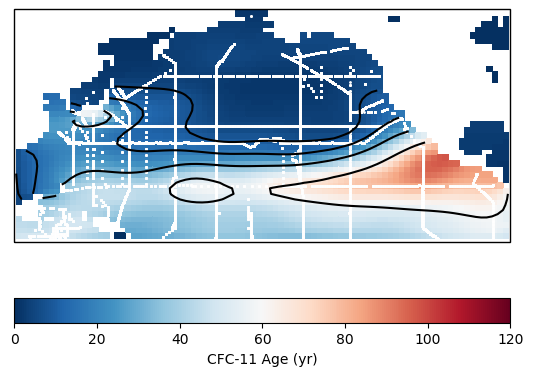

In [4]:
subdata = dropmissing(data,:cfc11_age)# sigma = 26.2
# subdata = subdata[ (subdata.sigma0 .> 26.1) .& (subdata.sigma0 .< 26.3),: ]
x = (mod1.(subdata.longitude,360),subdata.latitude,subdata.sigma0)
grid_intp = (xi,yi,zi)
cfc11_values = subdata.cfc11_age;
cfc11_grid,s = DIVAndrun(ocean_mask,grid_factors,grid_intp,x,cfc11_values,(correlation_scales),20.);
cfc11_grid[cfc11_grid .< 0] .= 0.

plt.figure()
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree(central_longitude=390/2))
cax = ax.pcolormesh(xi[:,:,1],yi[:,:,1],cfc11_grid[:,:,2],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r,vmin=0,vmax=120)
ax.scatter(subdata.longitude,subdata.latitude,s=1.,c="white",transform=ccrs.PlateCarree())
ax.contour(xi[:,:,1],yi[:,:,1],cfc11_grid[:,:,1],levels = [5,10,20,40,80,120],transform=ccrs.PlateCarree(),colors="black")
ax.set_extent([110,280,-10,70],crs=ccrs.PlateCarree())
plt.colorbar(cax,label = "CFC-11 Age (yr)",orientation="horizontal")
plt.show()

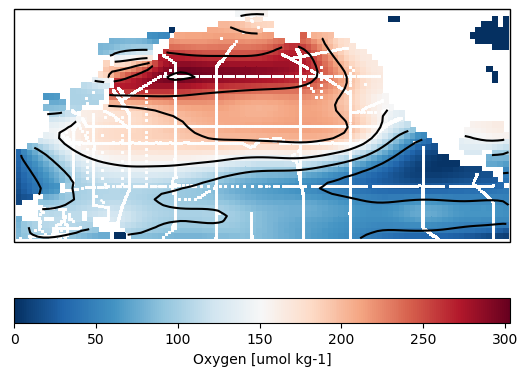

PyObject <matplotlib.colorbar.Colorbar object at 0x7f19b50ce908>

In [5]:
o2data = data[(data.oxygenqc .== 1) .& (data.oxygen.>0),:]
x = (mod1.(o2data.longitude,360),o2data.latitude,o2data.sigma0)
o2_values = o2data.oxygen
o2_grid,s = DIVAndrun(ocean_mask,grid_factors,grid_intp,x,o2_values,correlation_scales,10.);
o2_grid[o2_grid.<0] .= 0.

plt.figure()
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree(central_longitude=390/2))
cax = ax.pcolormesh(xi[:,:,1],yi[:,:,1],o2_grid[:,:,1],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)
ax.scatter(o2data.longitude,o2data.latitude,s=1.,c="w",transform=ccrs.PlateCarree())
ax.contour(xi[:,:,1],yi[:,:,1],o2_grid[:,:,1],levels=range(0,stop=500,step=50),transform=ccrs.PlateCarree(),colors="black")
ax.set_extent([110,280,-10,70],crs=ccrs.PlateCarree())
# ax.gridlines()
# ax.coastlines()
plt.colorbar(cax,label = "Oxygen [umol kg-1]",orientation="horizontal")
# plt.show()

In [6]:
grid2d_intp = (xi[:,:,1],yi[:,:,1]);
mask_2d     = ocean_mask[:,:,1];
grid2d_factors = (grid_factors[1][:,:,1],grid_factors[2][:,:,1]);

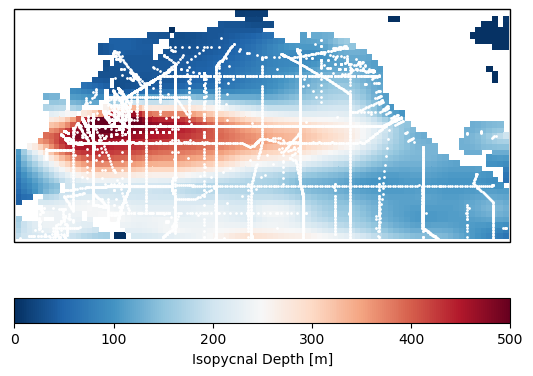

PyObject <matplotlib.colorbar.Colorbar object at 0x7f19c1f6c2b0>

In [7]:
sigma_z_grid = ones(size(o2_grid))*NaN

for (idx, sigma) in enumerate(sigmas)
    subdata = dropmissing(isopycnal_depths[:,[2,3,idx+4]])    
    x = (mod1.(subdata.longitude,360),subdata.latitude)
    sigma_z_grid[:,:,idx],s = DIVAndrun(mask_2d,grid2d_factors,grid2d_intp,x,subdata[!,3],(10.,5.),10);
end

sigma_z_grid[sigma_z_grid .< 0.] .= NaN

plt.figure()
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree(central_longitude=390/2))
cax = ax.pcolormesh(xi[:,:,1],yi[:,:,1],sigma_z_grid[:,:,1],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r,vmin=0,vmax=500)
ax.scatter(subdata.longitude,subdata.latitude,s=1.,c="w",transform=ccrs.PlateCarree())
ax.set_extent([110,280,-10,70],crs=ccrs.PlateCarree())
plt.colorbar(cax,label = "Isopycnal Depth [m]",orientation="horizontal")


In [8]:
o2atts = Dict(
    "units" => "umol kg-1",
    "long_name" => "concentration of oxygen in seawater")
ageatts = Dict(
    "units" => "years",
    "long_name" => "age of seawater inferred from 1d TTD method using pCFC-11"
    )
sigmaatts = Dict(
    "units" => "kg m-3",
    "long_name" => "potential density anomaly referenced to 0 dbar"
    )
sigma_z_atts = Dict(
    "units" => "m",
    "long_name" => "depth of the potential density anomaly surface"
    )
fname = "gridded_oxygen_age_sigma_z.nc"
nccreate(fname,"o2","lon",masklon[lonidx],"lat",reverse(masklat[latidx]),"sigma0",sigmas,sigmaatts,atts=o2atts)
nccreate(fname,"cfc11_age","lon",masklon[lonidx],"lat",reverse(masklat[latidx]),"sigma0",sigmas,sigmaatts,atts=ageatts)
nccreate(fname,"sigma_z","lon",masklon[lonidx],"lat",reverse(masklat[latidx]),"sigma0",sigmas,sigmaatts,atts=sigma_z_atts)
ncwrite(o2_grid,fname,"o2")
ncwrite(cfc11_grid,fname,"cfc11_age")
ncwrite(sigma_z_grid,fname,"sigma_z")

ErrorException: Variable o2 already exists in file gridded_oxygen_age_sigma_z.nc